In [1]:
import pandas as pd

import numpy as np

from scipy.stats.qmc import PoissonDisk
from shapely import Point, Polygon, MultiPolygon
import geopandas as gpd


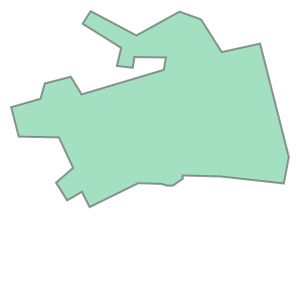

In [2]:

local_crs = 32636
border: Polygon = gpd.read_file('Аэродром Сиверск .geojson').to_crs(local_crs).union_all()
areas_dict = {
        "residential": 0.1,
        "industrial": 0.1,
        "business": 0.1,
        "recreation": 0.1,
        "transport": 0.1,
        "agricalture": 0.1,
        "special": 0.1,
    }
border

In [8]:
import geopandas as gpd
from gen_planner.python.src.genplanner import GenPlanner
from func_zones import func_zones

res = GenPlanner(gpd.read_file('Аэродром Сиверск .geojson'),0).zone2block(None,func_zones.residential)

start init
inside zone2block
delimeters: [5, 6]
to_split: [5]
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
to_split: [6, 5, 5, 5, 5]
{0: 0.16666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666}
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}


In [9]:

m1 = gpd.GeoDataFrame(geometry=res[0],crs=32636).explore()
gpd.GeoDataFrame(geometry=res[1], crs=32636).buffer(-10).explore(m=m1,color='red')
gpd.GeoDataFrame(geometry=res[2], crs=32636).buffer(-10).explore(m=m1,color='green')

m1

In [11]:
m1

In [25]:
from shapely.geometry import Polygon
import math
from typing import List, Tuple


def rectangle_angle(rect: Polygon) -> tuple:
    if not isinstance(rect, Polygon) or len(rect.exterior.coords) != 5:
        raise ValueError("Переданный объект не является прямоугольником.")
    coords = list(rect.exterior.coords)[:-1]
    sides = [(coords[0], coords[1]), (coords[1], coords[2])]

    lengths = [
        math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        for (x1, y1), (x2, y2) in sides
    ]
    long_side_idx = lengths.index(max(lengths))
    long_side = sides[long_side_idx]

    (x1, y1), (x2, y2) = long_side
    angle_rad = math.atan2(y2 - y1, x2 - x1)
    return angle_rad


def rotate_coordinates(coords: list, pivot: Point, angle_rad: float) -> List[Tuple[float, float]]:
    px, py = pivot.x, pivot.y
    rotated_coords = []
    for x, y in coords:
        translated_x = x - px
        translated_y = y - py

        rotated_x = translated_x * math.cos(angle_rad) - translated_y * math.sin(angle_rad)
        rotated_y = translated_x * math.sin(angle_rad) + translated_y * math.cos(angle_rad)

        final_x = rotated_x + px
        final_y = rotated_y + py
        rotated_coords.append((final_x, final_y))
    return rotated_coords


angle = rectangle_angle(border.minimum_rotated_rectangle)

rotated = rotate_coordinates(border.exterior.coords, border.centroid, -angle)
rotated_bounds = Polygon(rotated)



In [26]:

def normalize_polygon(polygon, bounds):
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a Shapely Polygon")

    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny
    scale = max(width, height)

    # Центрирование полигона
    cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
    normalized_coords = [
        ((x - cx) / scale + 0.5, (y - cy) / scale + 0.5)
        for x, y in polygon.exterior.coords
    ]

    return Polygon(normalized_coords)


bounds = rotated_bounds.bounds
normalized_border = normalize_polygon(rotated_bounds.buffer(5), bounds)


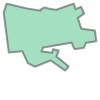

In [27]:
normalized_border

In [28]:

def generate_points(area_to_fill: Polygon | MultiPolygon, radius, seed=None):
    if seed is None:
        seed = np.random.default_rng()

    bbox = area_to_fill.envelope
    min_x, min_y, max_x, max_y = bbox.bounds

    width = max_x - min_x
    height = max_y - min_y

    norm_radius = radius / max(width, height)

    engine = PoissonDisk(d=2, radius=norm_radius, seed=seed)
    points = engine.random(int(bbox.area // (math.pi * radius ** 2)) * 10)

    points[:, 0] = points[:, 0] * width + min_x
    points[:, 1] = points[:, 1] * height + min_y

    points_in_polygon = np.array([point for point in points if area_to_fill.contains(Point(point))])

    return points_in_polygon


poisson_points = generate_points(normalized_border, 0.1)
# m1 = gpd.GeoDataFrame(geometry=[border],crs=local_crs).explore()
# gpd.GeoDataFrame(geometry=points,crs=local_crs).explore(m=m1,color='red')

In [29]:
full_area = normalized_border.area
areas = pd.DataFrame(list(areas_dict.items()), columns=['zone_name', 'ratio'])
areas['ratio'] = areas['ratio'] / areas['ratio'].sum()
areas['area'] = areas['ratio'] * full_area
areas.sort_values(by='ratio', ascending=True, inplace=True)
area_per_site = full_area / (len(poisson_points))
areas['site_indeed'] = round(areas['area'] / area_per_site).astype(int)
zones = np.random.permutation(np.repeat(areas.index, areas['site_indeed']))
poisson_points = poisson_points[:len(zones)]
zones = zones[:len(poisson_points)].astype(int)

In [30]:
normalized_border = [round(item, 8) for sublist in normalized_border.exterior.coords[::-1] for item in sublist]

In [31]:
import rust_optimizer

res = rust_optimizer.optimize_space(vtxl2xy=normalized_border,
                                    site2xy=poisson_points.flatten().round(8).tolist(),
                                    site2room=zones.tolist(),
                                    site2xy2flag=[0.0 for _ in range(len(zones) * 2)],
                                    room2area_trg=areas['area'].sort_index().round(8).tolist(),
                                    room_connections=[],
                                    create_gif=False
                                    )

In [32]:
from shapely.geometry import Polygon


def denormalize_coords(normalized_coords, bounds):
    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny
    scale = max(width, height)

    cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
    denormalized_coords = [
        (
            (x - 0.5) * scale + cx,
            (y - 0.5) * scale + cy
        )
        for x, y in normalized_coords
    ]

    return denormalized_coords


In [33]:
from shapely import LineString
from shapely.ops import polygonize, unary_union

normalized_points = [x for x in np.array(res[1]).reshape(int(len(res[1]) / 2), 2)]
new_roads = [denormalize_coords((normalized_points[x[0]], normalized_points[x[1]]), bounds) for x in
             np.array(res[0]).reshape(int(len(res[0]) / 2), 2)]
new_roads = [LineString(x) for x in new_roads]

roads_w_border = new_roads + [LineString(rotated_bounds.exterior.coords)]

devided_zones = gpd.GeoDataFrame(geometry=list(polygonize((unary_union(roads_w_border).simplify(50)))), crs=local_crs)


In [34]:
centroids = denormalize_coords([x for x in np.array(res[2]).reshape(int(len(res[2]) / 2), 2)], bounds)
centroids = gpd.GeoDataFrame(data={'zone': zones}, geometry=[Point(x) for x in centroids], crs=local_crs)


In [35]:
devided_zones = devided_zones.sjoin(centroids, how='left').groupby('zone').agg({'geometry': 'first'}).reset_index()

In [36]:

devided_zones = devided_zones.merge(areas.reset_index(), left_on='zone', right_on='index').drop(
    columns=['index', 'area', 'site_indeed'])


In [37]:
max_block_size_dict = {'industrial': 500000,
                       'residential': 500000,
                       'recreation': 400000,
                       'business': 200000,
                       'agro': 400000}
devided_zones = devided_zones.set_geometry('geometry').set_crs(local_crs)
devided_zones['area'] = devided_zones.area
# devided_zones['n_split'] = devided_zones.apply(lambda x: x.area // max_block_size_dict.get(x.zone_name), axis=1)
devided_zones

,zone,geometry,zone_name,ratio,area
0,0,"POLYGON ((331470.09 6582857.67, 331485.907 658...",residential,0.125,226405.858737
1,1,"POLYGON ((331015.147 6583806.038, 331244.137 6...",industrial,0.125,598524.145366
2,2,"POLYGON ((331485.907 6582890.286, 331470.09 65...",business,0.125,472292.314640
3,3,"POLYGON ((330817.03 6583995.706, 330783.189 65...",recreation,0.125,558223.248839
4,4,"POLYGON ((332200.642 6584429.976, 332262.289 6...",transport,0.125,670029.553209
5,5,"POLYGON ((332262.289 6584121.551, 332200.642 6...",agricalture,0.125,802625.846782
6,6,"POLYGON ((330825.414 6582779.324, 331252.335 6...",special,0.125,202559.130165
7,7,"POLYGON ((331241.659 6584201.267, 331244.137 6...",pukich,0.125,647150.112849


In [39]:
test = devided_zones.set_geometry('geometry').set_crs(local_crs)
test.geometry = test.geometry.rotate(angle, border.centroid, use_radians=True)
test.explore(column='zone_name', cmap='viridis', tiles='CartoDB positron')

In [25]:
devided_zones_splitted = []

for i, row in devided_zones.iterrows():
    if row.n_split > 1:
        n_split = row.n_split

        cur_poly_bounds = row.geometry
        bounds = cur_poly_bounds.bounds
        normalized_border = normalize_polygon(cur_poly_bounds.buffer(5), bounds)
        poisson_points = generate_points(normalized_border, 0.1)
        full_area = normalized_border.area

        areas = pd.DataFrame(data=[row.zone_name for _ in range(int(n_split))], columns=['zone_name'])
        areas['area'] = full_area / n_split
        area_per_site = full_area / (len(poisson_points))
        areas['site_indeed'] = round(areas['area'] / area_per_site).astype(int)
        zones = np.random.permutation(np.repeat(areas.index, areas['site_indeed']))
        poisson_points = poisson_points[:len(zones)]
        zones = zones[:len(poisson_points)].astype(int)
        normalized_border = [round(item, 8) for sublist in normalized_border.exterior.coords[::-1] for item in sublist]
        res = rust_optimizer.optimize_space(vtxl2xy=normalized_border,
                                            site2xy=poisson_points.flatten().round(8).tolist(),
                                            site2room=zones.tolist(),
                                            site2xy2flag=[0.0 for _ in range(len(zones) * 2)],
                                            room2area_trg=areas['area'].sort_index().round(8).tolist(),
                                            room_connections=[],
                                            create_gif=False
                                            )
        normalized_points = [x for x in np.array(res[1]).reshape(int(len(res[1]) / 2), 2)]
        new_roads_2 = [denormalize_coords((normalized_points[x[0]], normalized_points[x[1]]), bounds) for x in
                       np.array(res[0]).reshape(int(len(res[0]) / 2), 2)]
        new_roads_2 = [LineString(x) for x in new_roads_2]

        roads_w_border_2 = new_roads_2 + [LineString(cur_poly_bounds.exterior.coords)]

        devided_zones_inside = gpd.GeoDataFrame(geometry=list(polygonize((unary_union(roads_w_border_2)))),
                                                crs=local_crs)
        centroids = denormalize_coords([x for x in np.array(res[2]).reshape(int(len(res[2]) / 2), 2)], bounds)
        centroids = gpd.GeoDataFrame(data={'zone': zones}, geometry=[Point(x) for x in centroids], crs=local_crs)
        devided_zones_inside = devided_zones_inside.sjoin(centroids, how='left').groupby('zone').agg(
            {'geometry': 'first'}).reset_index()
        devided_zones_inside = devided_zones_inside.merge(areas.reset_index(), left_on='zone', right_on='index').drop(
            columns=['index', 'area', 'site_indeed'])

        devided_zones_splitted.append(devided_zones_inside)
    else:
        devided_zones_splitted.append(row.to_frame().transpose())


In [26]:
test = pd.concat(devided_zones_splitted, ignore_index=True).set_geometry('geometry').set_crs(local_crs)
test.geometry = test.geometry.rotate(angle, border.centroid, use_radians=True)

In [27]:
test.explore(column='zone_name', cmap='viridis', tiles='CartoDB positron')

In [2]:
from gen_planner.python.src.func_zones import bs

In [5]:
bs.industrial_territory